# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] ##

In this assignment you will get familiar with basic and advanced information retrieval concepts. You will implement different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Wednesday, January 31st**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](piazza.com/university_of_amsterdam/spring2018/52041inr6y/home).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [1]:
import logging
import sys
import os

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)
            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [2]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [3]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [4]:
example_document = index.document(index.document_base())
print(example_document)

('AP890425-0001', (1360, 192, 363, 0, 880, 0, 200, 0, 894, 412, 92160, 3, 192, 0, 363, 34, 1441, 0, 174134, 0, 200, 0, 894, 412, 2652, 0, 810, 107, 49, 4903, 420, 0, 1, 48, 35, 489, 0, 35, 687, 192, 243, 0, 249311, 1877, 0, 1651, 1174, 0, 2701, 117, 412, 0, 810, 391, 245233, 1225, 5838, 16, 0, 233156, 3496, 0, 393, 17, 0, 2435, 4819, 930, 0, 0, 200, 0, 894, 0, 22, 398, 145, 0, 3, 271, 115, 0, 1176, 2777, 292, 0, 725, 192, 0, 0, 50046, 0, 1901, 1130, 0, 192, 0, 408, 0, 243779, 0, 0, 553, 192, 0, 363, 0, 3747, 0, 0, 0, 0, 1176, 0, 1239, 0, 0, 1115, 17, 0, 0, 585, 192, 1963, 0, 0, 412, 54356, 0, 773, 0, 0, 0, 192, 0, 0, 1130, 0, 363, 0, 545, 192, 0, 1174, 1901, 1130, 0, 4, 398, 145, 39, 0, 577, 0, 355, 0, 491, 0, 6025, 0, 0, 193156, 88, 34, 437, 0, 0, 1852, 0, 828, 0, 1588, 0, 0, 0, 2615, 0, 0, 107, 49, 420, 0, 0, 190, 7, 714, 2701, 0, 237, 192, 157, 0, 412, 34, 437, 0, 0, 200, 6025, 26, 0, 0, 0, 0, 363, 0, 22, 398, 145, 0, 200, 638, 126222, 6018, 0, 880, 0, 0, 161, 0, 0, 319, 894, 2701, 

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [5]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]


Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [6]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [7]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [8]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [9]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

# Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [10]:
import time

with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

start_time = time.time()

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 24.52208709716797 seconds.


In [11]:
print(tokenized_queries)

{'51': [5872, 3066], '52': [54, 846, 2208], '53': [4886, 48553], '54': [2231, 1339, 1490], '55': [4400, 235], '56': [389, 4081, 241, 2294, 190739], '57': [155285], '58': [3454, 1920], '59': [804, 955, 90480], '60': [157422, 213, 215481], '61': [358, 523, 335, 1098, 2598], '62': [55, 64853, 73364], '63': [2129, 243152], '64': [1987, 451], '65': [281, 202871, 982], '66': [1535, 1434, 3628], '67': [3698, 5802, 416, 76611], '68': [248, 111208, 1322, 74181, 91961], '69': [2354, 203193, 3177, 811, 942], '70': [233033, 163926], '71': [580, 120650], '72': [71970, 218232, 5465, 276], '73': [71970, 218232, 21, 43984], '74': [61863, 238], '75': [30473], '76': [5465, 276, 1633, 1704, 3895], '77': [188098], '78': [105220], '79': [96348, 78, 33, 1801], '80': [214, 252, 789, 187515], '81': [380, 66582, 237310, 3367, 3383, 1893], '82': [5967, 3067], '83': [1122, 1189, 2783], '84': [2563, 201208, 601, 351, 851, 122153], '85': [85, 2181], '86': [140, 89553], '87': [819, 1533, 485, 629, 380, 1644], '88':

In [12]:
# imports
from functools import partial
import numpy as np
import subprocess
import math
import pickle
import pandas as pd
from collections import defaultdict
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_rel
from IPython.display import display

## Creating TREC run files

Function <font color='blue'>run_retrieval</font> runs a retrieval method for all the topic queries and stores the TREC-friendly results in a file (<font color='blue'>model_name.run</font>). It is generic, since it handles any of the implemented score functions of Task 1 (except PLM scoring) in the same way. The score of each topic query for a document is the sum of the scores of each topic query term upon the document.

**Note:** If a run filename already exists, then it returns immediately.

In [13]:
def run_retrieval(model_name, score_fn):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)

    data = {}

    # Fill the data dictionary. 
    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
    
    start_time = time.time()
    
    for doc in range(index.document_base(), num_documents+1):
        # Skip empty documents
        if index.document_length(doc) == 0:
            continue
        
        # Get document id
        ext_doc_id = index.document(doc)[0]
        
        # Iterate over topic queries
        for query_id in tokenized_queries.keys():
            if query_id not in data.keys():
                data[query_id] = []
            score = 0   
            # Iterate over terms of topic query and calculate score
            for query_term_id in tokenized_queries[query_id]:
                if doc not in inverted_index[query_term_id]:
                    document_term_freq = 0
                else:
                    document_term_freq = inverted_index[query_term_id][doc]
                score += score_fn(doc, query_term_id, document_term_freq)
            data[query_id].append((score, ext_doc_id))
    
    # Transform to tuples
    for query_id in data.keys():
        data[query_id] = tuple(data[query_id])
    
    # Save to file
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)
    
    print('Retrieved in {0} seconds'.format(time.time() - start_time))
    print()

## Score methods and results
The required score methods are implemented here. After the implementation, the steps followed for each method were:

1. Creation of the run files. If a score method has hyperameters that are asked to be optimized, then different run files are created for each of them. For instance, in Jelinek-Mercer we are asked to optimize the interpolation hyperparameter $\lambda$ within the range of values [0.1, 0.5, 0.9]. This allows us to evaluate the scoring of each run file upon the validation set and choose the best of them.

2. **(if applicable)** Get the evaluation results (NDCG@10, M.A.P.@1000, Precision@5, Recall@1000) for different hyperparameters of each model upon the <em>validation set</em>. Choose the one with the best score in NDCG@10.

3. Get the evaluation results (same as above) of each model upon the <em>test set</em>.

Function <font color='blue'>evaluate</font> calculates NDCG@10, MAP@1000, Precision@5, Recall@1000 evaluation measures of a given run file upon a evaluation set.  This is done by invoking a trec_eval bash script (<font color='blue'>run_trec_validation.sh</font>). The results are stored in a dictionary structure:

{'ndcg_cut_10' : {query1 : score1, ..., 'all' : score}, 'map_cut_1000' : {query1 : score1, ..., 'all' : score},
'P_5' : {query1 : score1, ..., 'all' : score}, 'recall_1000' : {query1 : score1, ..., 'all' : score}}

In [14]:
def evaluate(evaluation_set, run_model):
    """ Invokes trec and returns all the results on NDCG@10, MAP@1000, Precision@5, Recall@1000.
    
    Key arguments:
    evaluation_set -- The name of the qrel file.
    run_model -- The name of the run file.
    """
    # Set up the trec script and direct the output to a pipe
    run_model += ".run"
    p1 = subprocess.Popen(['./run_trec_validation.sh', evaluation_set, run_model], stdout=subprocess.PIPE)
    
    # Run the command
    output = p1.communicate()[0]
    
    # Save the results
    results = {}
    for line in output.decode('utf8').splitlines():
        tokens = line.split()
        if tokens[0] not in results:
            results[tokens[0]] = {}
        results[tokens[0]][tokens[1]] = tokens[2]
    return results

validation_set = "./ap_88_89/qrel_validation"
test_set = "./ap_88_89/qrel_test"

### 1. TF-IDF

TFIDF weight of a term upon a document d is the product of its td weight and its idf weight:
$$tfidf(t;d) = log(1+tf(t;d))\log{\frac{n}{df(t)}}$$

, n is the number of documents.

In [15]:
def tfidf(int_document_id, query_term_id, document_term_freq):
    """
    TF-IDF scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """
    df = len(inverted_index[query_term_id]) 
    idf = np.log(num_documents/df)
    score = np.log(1+document_term_freq) * idf
    return score

#### TF-IDF: Results upon the test set.

In [16]:
run_retrieval('tfidf', tfidf)
TFIDF_results = evaluate(test_set, "tfidf")
print("TF-IDF has the following scores upon the test set:")
print("nDCG@10:\t{0}".format(TFIDF_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(TFIDF_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(TFIDF_results['P_5']['all']))
print("Recall@1000:\t{0}".format(TFIDF_results['recall_1000']['all']))

TF-IDF has the following scores upon the test set:
nDCG@10:	0.4169
MAP@1000:	0.2155
Precision@5:	0.4317
Recall@1000:	0.6510


### 2. BM25 with k1=1.2 and b=0.75

BM25 estimates a score of a document with the following:

$$BM25 = \sum_{t\in q}{\frac {(k_1+1)tf_{d,t}} {k_1((1-b) + b(\frac{l_d}{l_{avg}})) + tf_{d,t}} idf(t)}$$

In [17]:
def BM25(int_document_id, query_term_id, document_term_freq, k1=1.2, b=0.75):
    """
    """
    # Calculate remaining parameters:
    df = len(inverted_index[query_term_id]) 
    idf = np.log(num_documents/df)
    ld = document_lengths[int_document_id]
    lavg = avg_doc_length
    
    # Calculate final score:
    numerator = (k1+1)*document_term_freq*idf
    nominator = k1*((1-b) + b*(ld/lavg)) + document_term_freq
    score = numerator/nominator
    return score

#### BM25: Results upon the test set.

In [18]:
run_retrieval('bm25', BM25)
BM25_results = evaluate(test_set, "bm25")
print("BM25 has the following scores upon the test set:")
print("nDCG@10:\t{0}".format(BM25_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(BM25_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(BM25_results['P_5']['all']))
print("Recall@1000:\t{0}".format(BM25_results['recall_1000']['all']))

BM25 has the following scores upon the test set:
nDCG@10:	0.4086
MAP@1000:	0.2173
Precision@5:	0.4133
Recall@1000:	0.6524


## 3. Language Models

### 3.1 Jelinek-Mercer

Jelinek-Mercer is a Multinomial Smoothing method that estimates the score for a term $w$ given a document $d$ by using interpolation. Julinek-Mercer probability of a given term and document is estimated as follows:
$$\hat{P_{\lambda}}(w\mid d) = \lambda\frac{tf(w;d)}{\mid d\mid} + (1-\lambda)\frac{tf(w;C)}{\mid C\mid}$$

In [19]:
def JelinekMercer(int_document_id, query_term_id, document_term_freq, lambda_param=0.5):
    """
    Jelinek-Mercer scoring function for a document and a query term.
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    :param lambda_param: the lambda parameter used in the calculation of Jelinek-Mercer score
    """
    # Get remaining parameters
    doc_length = document_lengths[int_document_id]
    collection_term_freq = collection_frequencies[query_term_id]
    
    # Calculate (log) score
    score = np.log(lambda_param*(document_term_freq/doc_length) + \
                   (1-lambda_param)*(collection_term_freq/total_terms))
    return score

#### Jelinek-Mercer: Optimization of hyperparameter $\lambda$

In [20]:
# Get run file for λ=0.1
JelinekMercer01 = partial(JelinekMercer, lambda_param = 0.1)
run_retrieval('JelinekMercer01', JelinekMercer01)

# Get run file for λ=0.5
JelinekMercer05 = partial(JelinekMercer, lambda_param = 0.5)
run_retrieval('JelinekMercer05', JelinekMercer05)

# Get run file for λ=0.9
JelinekMercer09 = partial(JelinekMercer, lambda_param = 0.9)
run_retrieval('JelinekMercer09', JelinekMercer09)

# Get all evaluation results.
JM_results_01 = evaluate(validation_set, "JelinekMercer01")
JM_results_05 = evaluate(validation_set, "JelinekMercer05")
JM_results_09 = evaluate(validation_set, "JelinekMercer09")

# Choose the best hyperparameter according to the scores of NDCG@10
print("Jelinek-Mercer with λ=0.1 scored {0} for nDCG@10.".format(JM_results_01['ndcg_cut_10']['all']))
print("Jelinek-Mercer with λ=0.5 scored {0} for nDCG@10.".format(JM_results_05['ndcg_cut_10']['all']))
print("Jelinek-Mercer with λ=0.9 scored {0} for nDCG@10.".format(JM_results_09['ndcg_cut_10']['all']))
print("Best scored achieved for λ = 0.1.")

Jelinek-Mercer with λ=0.1 scored 0.3991 for nDCG@10.
Jelinek-Mercer with λ=0.5 scored 0.3823 for nDCG@10.
Jelinek-Mercer with λ=0.9 scored 0.3676 for nDCG@10.
Best scored achieved for λ = 0.1.


#### Jelinek-Mercer: Results upon the test set.

In [21]:
JM_results = evaluate(test_set, "JelinekMercer01")
print("Jelinek-Mercer with λ=0.1 has the following scores upon the test set:")
print("nDCG@10:\t{0}".format(JM_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(JM_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(JM_results['P_5']['all']))
print("Recall@1000:\t{0}".format(JM_results['recall_1000']['all']))

Jelinek-Mercer with λ=0.1 has the following scores upon the test set:
nDCG@10:	0.3489
MAP@1000:	0.1893
Precision@5:	0.3450
Recall@1000:	0.6203


### 3.2 Dirichlet Prior

Dirichlet Prior Smoothing for a term given a document is estimated by the following equation:
$$p(w\mid \hat{\theta_d}) = \frac{tf(w;d) + \mu p(w\mid C)}{\mid d\mid + \mu}$$

In [22]:
def DirichletPrior(int_document_id, query_term_id, document_term_freq, mu=1000):
    """
    Dirichlet Prior scoring function for a document and a query term.
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    :param lambda_param: the lambda parameter used in the calculation of Jelinek-Mercer score
    """
    # Get remaining parameters
    doc_length = document_lengths[int_document_id]
    collection_term_prob = collection_frequencies[query_term_id]/total_terms
    
    # Calculate (log) score
    score = np.log((document_term_freq + mu*collection_term_prob)/(doc_length+mu))
    return score

#### Dirichlet Prior Smoothing: Optimization of hyperparameter $\mu$

In [23]:
# Get run file for μ=500
DirichletPrior500 = partial(DirichletPrior, mu=500)
run_retrieval('DirichletPrior500', DirichletPrior500)

# Get run file for μ=1000
DirichletPrior1000 = partial(DirichletPrior, mu=1000)
run_retrieval('DirichletPrior1000', DirichletPrior1000)

# Get run file for μ=1500
DirichletPrior1500 = partial(DirichletPrior, mu=1500)
run_retrieval('DirichletPrior1500', DirichletPrior1500)

# Get all evaluation results.
DP_results_500 = evaluate(validation_set, "DirichletPrior500")
DP_results_1000 = evaluate(validation_set, "DirichletPrior1000")
DP_results_1500 = evaluate(validation_set, "DirichletPrior1500")

# Choose the best hyperparameter according to the scores of NDCG@10
print("Dirichlet Prior with μ=500 scored {0} for nDCG@10.".format(DP_results_500['ndcg_cut_10']['all']))
print("Dirichlet Prior with μ=1000 scored {0} for nDCG@10.".format(DP_results_1000['ndcg_cut_10']['all']))
print("Dirichlet Prior with μ=1500 scored {0} for nDCG@10.".format(DP_results_1500['ndcg_cut_10']['all']))
print("Best scored achieved for μ = 500.")

Dirichlet Prior with μ=500 scored 0.4055 for nDCG@10.
Dirichlet Prior with μ=1000 scored 0.4002 for nDCG@10.
Dirichlet Prior with μ=1500 scored 0.4026 for nDCG@10.
Best scored achieved for μ = 500.


#### Dirichlet Prior Smoothing: Results upon the test set.

In [24]:
DP_results = evaluate(test_set, "DirichletPrior500")
print("Dirichlet Prior with μ=500 has the following scores upon the test set:")
print("nDCG@10:\t{0}".format(DP_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(DP_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(DP_results['P_5']['all']))
print("Recall@1000:\t{0}".format(DP_results['recall_1000']['all']))

Dirichlet Prior with μ=500 has the following scores upon the test set:
nDCG@10:	0.4085
MAP@1000:	0.2104
Precision@5:	0.4200
Recall@1000:	0.6287


### 3.3 Absolute discounting

Absolute Discounting score is estimated by the following:

$$p_{\delta}(w\mid \hat{\theta_d}) = \frac{max(tf(w;d) - \delta, 0)}{\mid d\mid} + \frac{\delta\mid d\mid_u}{\mid d\mid}p(w\mid C)$$

In [25]:
def AbsoluteDiscounting(int_document_id, query_term_id, document_term_freq, delta=0.5):
    """
    Absolute Discounting scoring function for a document and a query term.
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    :param lambda_param: the lambda parameter used in the calculation of Jelinek-Mercer score
    """
    # Get remaining parameters
    doc_length = document_lengths[int_document_id]
    doc_voc = unique_terms_per_document[int_document_id]
    collection_term_prob = collection_frequencies[query_term_id]/total_terms
    
    # Calculate (log) score
    score = np.log(max((document_term_freq-delta), 0)/doc_length + (delta*doc_voc*collection_term_prob)/doc_length)
    return score

#### Absolute Discounting: Optimization of hyperparameter $\delta$

In [26]:
# Get run file for δ=0.1
AbsoluteDiscounting01 = partial(AbsoluteDiscounting, delta = 0.1)
run_retrieval('AbsoluteDiscounting01', AbsoluteDiscounting01)

# Get run file for δ=0.5
AbsoluteDiscounting05 = partial(AbsoluteDiscounting, delta = 0.5)
run_retrieval('AbsoluteDiscounting05', AbsoluteDiscounting05)

# Get run file for δ=0.9
AbsoluteDiscounting09 = partial(AbsoluteDiscounting, delta = 0.9)
run_retrieval('AbsoluteDiscounting09', AbsoluteDiscounting09)

# Get all evaluation results.
AD_results_01 = evaluate(validation_set, "AbsoluteDiscounting01")
AD_results_05 = evaluate(validation_set, "AbsoluteDiscounting05")
AD_results_09 = evaluate(validation_set, "AbsoluteDiscounting09")

# Choose the best hyperparameter according to the scores of NDCG@10
print("Absolute Discounting with δ=0.1 scored {0} for nDCG@10.".format(AD_results_01['ndcg_cut_10']['all']))
print("Absolute Discounting with δ=0.5 scored {0} for nDCG@10.".format(AD_results_05['ndcg_cut_10']['all']))
print("Absolute Discounting with δ=0.9 scored {0} for nDCG@10.".format(AD_results_09['ndcg_cut_10']['all']))
print("Best scored achieved for δ = 0.9.")

Absolute Discounting with δ=0.1 scored 0.3614 for nDCG@10.
Absolute Discounting with δ=0.5 scored 0.3768 for nDCG@10.
Absolute Discounting with δ=0.9 scored 0.3950 for nDCG@10.
Best scored achieved for δ = 0.9.


#### Absolute Discounting: Results upon the test set.

In [27]:
AD_results = evaluate(test_set, "AbsoluteDiscounting09")
print("Absolute Discounting with δ=0.9 has the following scores upon the test set:")
print("nDCG@10:\t{0}".format(AD_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(AD_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(AD_results['P_5']['all']))
print("Recall@1000:\t{0}".format(AD_results['recall_1000']['all']))

Absolute Discounting with δ=0.9 has the following scores upon the test set:
nDCG@10:	0.3860
MAP@1000:	0.2031
Precision@5:	0.3983
Recall@1000:	0.6262


### 3.4 Positional Language Models (σ=50) 

The following methods are given two positions i and j and a σ value and calculate the propagated count to position i from a term at position j $w_j$. Five different kernelsare used to calculate the propagated counts:

1. Gaussian kernel
2. Triangle kernel
3. Cosine (Hamming) kernel
4. Circle kernel
5. Passage kernel

In [28]:
def gaussian_kernel(i,j,sigma=50):
    """Returns the propagated count using Gaussian kernel"""
    return np.exp(-((i-j)**2)/ (2*(sigma**2)))
    
def triangle_kernel(i,j,sigma=50):
    """Returns the propagated count using Triangle kernel"""
    return 1-(math.fabs(i-j)/sigma) if math.fabs(i-j) <= sigma else 0
    
def cosine_kernel(i,j,sigma=50):
    """Returns the propagated count using Cosine kernel"""
    return 0.5*(1+ math.cos((math.fabs(i-j)*math.pi)/sigma)) if math.fabs(i-j) <= sigma else 0
    
def circle_kernel(i,j,sigma=50):
    """Returns the propagated count using Circle kernel"""
    return math.sqrt(1-(math.fabs(i-j)/sigma)**2) if math.fabs(i-j) <= sigma else 0

def passage_kernel(i,j,sigma=50):
    """Returns the propagated count using Passage kernel"""
    return 1 if math.fabs(i-j) <= sigma else 0

#### Cumulative Distribution Functions

Since the calculation of the propagation count sums is computationally expensive, we decided to calculate them using the proposed solution from [Positional Language Models for Information Retrieval](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) which uses the Cumulative Distribution Functions of each kernel. This makes the calculation of $Z_i$'s much faster. The implementation follows the [C++ code](http://sifaka.cs.uiuc.edu/~ylv2/pub/plm/PLMRetEval.cpp) implemented by the authors of the paper.

In [29]:
def GaussianCDF(x, mean, sigma=50):
    """The Gaussian CDF"""
    x = (x-mean)/sigma
    if x == 0:
        res = 0.5
    else:
        oor2pi = 1/math.sqrt(2*math.pi)
        t = 1/(1 + 0.2316419*math.fabs(x))
        t *= oor2pi * math.exp(-0.5 * x * x) \
             * (0.31938153   + t  \
             * (-0.356563782 + t \
             * (1.781477937  + t  \
             * (-1.821255978 + t * 1.330274429))))
        if x >= 0:
            res = 1 - t
        else:
            res = t
    return res

def TriangleCDF(x, mean, sigma=50):
    """The Triangle CDF"""
    x = (x-mean)/sigma
    if x >= 1:
        res = sigma
    elif x < -1:
        res = 0
    elif x < 0:
        res = (sigma*(1-math.fabs(x))*(1-math.fabs(x)))/2
    else:
        res = sigma - (sigma*(1-x)*(1-x))/2
    return res

def CosineCDF(x, mean, sigma=50):
    """The Cosine CDF"""
    x = (x-mean)/sigma
    if x >= 1:
        res = sigma
    elif x < -1:
        res = 0
    elif x < 0:
        res = (sigma*(1 + x - math.sin(math.pi*x)/math.pi))/2
    else:
        res = sigma - (sigma*(1 - x + math.sin(math.pi*x)/math.pi))/2
    return res


def CircleCDF(x, mean, sigma=50):
    """The Circle CDF"""
    x = (x-mean)/sigma
    if x >= 1:
        res = (math.pi/2)*sigma
    elif x < -1:
        res = 0
    elif x < 0:
        res = sigma*(math.asin(x) + math.pi / 2 - math.sqrt(1-x*x))
    else:
        res = (math.pi - 2)*sigma - sigma*(math.asin(-x) + math.pi/2 - math.sqrt(1-x*x))
    return res

def PassageCDF():
    """The Passage CDF. (Note: there is no actual CDF for Passage kernel and a normalization method is followed)"""
    pass

The following function estimates the normalized length $Z_i$ of a document given:

1. A position i in the document
2. The length of the document
3. A propagation function (CDF of a kernel)
4. A σ value

In [30]:
def normalized_length_Zi(i, doc_length, prop_func, sigma=50):
    """Returns the normalized length of a document in a specific position.
    
    Keyword Arguments:
    i -- a position in the document
    doc_length -- the length of the document
    prop_func -- a kernel CDF
    sigma -- a sigma value
    """
    Zi = 0
    # Using Gaussian CDF
    if prop_func == GaussianCDF:
        Zi = math.sqrt(2*math.pi)*sigma*(prop_func(doc_length, i, sigma) - prop_func(0, i, sigma))
    # Using Passage CDF
    elif prop_func == PassageCDF:
        if sigma > doc_length - i:
            Zi += doc_length - i
        else:
            Zi += sigma
        if(sigma > i):
            Zi += i
        else:
            Zi += sigma + 1 if i > sigma else sigma
    # All other kernel CDFs
    else:
        Zi = prop_func(doc_length, i, sigma) - prop_func(0, i, sigma)
    return Zi

This is a helper dictionary that maps a kernel name to its corresponding kernel and CDF functions.

In [31]:
kernel_map = {"gaussian" : (gaussian_kernel, GaussianCDF),
              "triangle" : (triangle_kernel, TriangleCDF),
              "cosine"   : (cosine_kernel, CosineCDF), 
              "circle"   : (circle_kernel, CircleCDF),
              "passage"  : (passage_kernel, PassageCDF)
             }

#### Kernel Tables (for efficiency)
Since it is computationally expensive to compute the propagated counts during the retrieval, we decided to create all possible propagated count values beforehand and store them into a file **kernel_tables.pickle**. The following function does that.

In [32]:
def store_kernels():
    """Calculates all possible kernel operations upon all possible positions and stores them in a file."""
    start_time = time.time()
    print('Getting all kernel tables')
    
    start_time = time.time()    
    # Get the length of the largest document.
    max_len = max([document_lengths[doc] for doc in range(index.document_base(), num_documents+1)])
    
    # Create a kernel table for all possible positions for all possible kernels
    # kernel_table: name -> (i,j) -> float x, with i,j in [0, max_len-1] and x the score
    kernel_tables = {"gaussian" : {}, "triangle" : {}, "cosine" : {}, "circle" : {}, "passage" : {}}
    for i in range(max_len):
        for j in range(max_len):
            for kernel_name in kernel_tables.keys():
                kernel_tables[kernel_name][(i,j)] = kernel_map[kernel_name][0](i,j)
    
    # Store table in a file using pickle library
    p = open("kernel_tables.pickle","wb")
    pickle.dump(kernel_tables, p)
    print("Calculated kernel tables in {0} seconds.".format(time.time() - start_time))
    p.close()

If kernel_tables.pickle is not created then call store_kernels(). 
Then loading of the kernel table from the corresponding file is performed.

In [33]:
# If kernel_tables are not stored, then call store_kernels()
if not os.path.exists("kernel_tables.pickle"):
    store_kernels()

# Retrieve kernel tables
p = open("kernel_tables.pickle", 'rb')
kernel_table = pickle.load(p)
p.close()

#### Normalized lengths $Z_i$ (for efficiency)
For the same reason as with the propagated counts, we decided to calculate all possible normalized lengths $Z_i$'s before running the retrieval method. We produce all possible normalized lengths starting from the first position till the last position of the lengthest document. The structure is the saved in **Z.pickle** file.

In [34]:
def store_Zs():
    """Calculates all possible normalized lengths and stores them in a file."""
    start_time = time.time()
    print('Getting all normalized lengths')
    
    start_time = time.time()
    
    # Get the length of the largest document.
    max_len = max([document_lengths[doc] for doc in range(index.document_base(), num_documents+1)])
    
    # Create a normalized length vector dictionary for all possible positions for all possible kernels
    # Z: name -> i -> float x, with i in [0, max_len-1] and x the value Zi
    Z = {"gaussian" : {}, "triangle" : {}, "cosine" : {}, "circle" : {}, "passage" : {}}
    for length in range(1,max_len+1):
        for kernel_name in Z.keys():
            Z[kernel_name][length] = []
            for pos in range(length):
                Z[kernel_name][length].append(normalized_length_Zi(pos, length, kernel_map[kernel_name][1]))
    
    # Store table in a file using pickle library
    p = open("Z.pickle","wb")
    pickle.dump(Z, p)
    print("Calculated normalized lengths in {0} seconds.".format(time.time() - start_time))
    p.close()

If Z.pickle is not created then call store_Zs(). 
Then loading of the normalized lengthes from the corresponding file is performed.

In [35]:
# If Z is not stored, then call store_Zs()
if not os.path.exists("Z.pickle"):
    store_Zs()

# Retrieve Z vectors
p = open("Z.pickle", 'rb')
Z = pickle.load(p)
p.close()

#### Propagated Count

The propagated count is calculated with the following function.

In [36]:
def propagated_count(query_term_id, int_document_id, pos, kernel_name, positions):
    occurrences = positions[query_term_id]
    return sum([kernel_table[kernel_name][(pos, j)] for j in occurrences])

#### Dirichlet smoothed PLM

We decided to apply Dirichlet smoothing for the implementation of the PLMs. 

In [37]:
def Dirichlet_smoothed_PLM(query_term_id, int_document_id, pos, kernel_name, positions, mu=500):
    # Propagated count
    pc = propagated_count(query_term_id, int_document_id, pos, kernel_name, positions)
    # General collection Language Model propability
    collection_term_prob = collection_frequencies[query_term_id]/total_terms
    # The length of the document
    doc_length = document_lengths[int_document_id]
    # The propagated count sum in position i
    Zi = Z[kernel_name][doc_length][pos]
    
    return (pc+mu*collection_term_prob)/(Zi+mu)
    

#### Scoring at position i

KL-Divergence is the metric that we use to estimate the score of a query upon a specific position of a document.
Only the query terms contribute to the score, since other terms produce zero result to their contribution in the summation since the MLE of them is 0.

In [38]:
def KLdivergence(query_id, int_document_id, pos, kernel_name, positions, mu=500):
    score = 0
    query_len = len(tokenized_queries[query_id])
    # Calculate the contribution of each query term to the score
    for query_term_id in tokenized_queries[query_id]:
        # Maximum Likelihood Estimate
        tf = len([t for t in tokenized_queries[query_id] if t == query_term_id])
        pr = tf/query_len
        # The Dirichlet smoothed PLM
        plm = Dirichlet_smoothed_PLM(query_term_id, int_document_id, pos, kernel_name, positions, mu)
        # Score summation
        score += pr*np.log(pr/plm)
    return -score

#### Best position stategy

In [39]:
def best_position_strategy(query_id, int_document_id, positions, mu=500):
    doc_length = document_lengths[int_document_id]
    pos_scores = {"gaussian" : [], "triangle" : [], "cosine" : [], "circle" : [], "passage" : []}
    
    for kernel_name in pos_scores.keys():
        for pos in range(doc_length):
            pos_scores[kernel_name].append(KLdivergence(query_id, int_document_id, pos, kernel_name, positions, mu))
        
        pos_scores[kernel_name] = max(pos_scores[kernel_name])
    return pos_scores

#### TF-IDF reranking

Since PLMs are very computationally expensive, the ranking of all the documents for each query needs a huge amount of time to be calculated. For that reason, we decided to rerank the top k documents of the results of the best performing ranking method. TF-IDF scored the highest value of NDCG@10, therefore we made the following restrictions:

1. For the **hyperparameter optimization** upon the validation set we rerank the top **100** ranked documents of TF-IDF
2. For the scoring, we use the best performing setting upon the validation set. We rerank the top **100** documents of TF-IDF

The following function retrieves the top n documents of the TF-IDF results:

In [40]:
def get_tfidf_rankings(n=100):
    
    # Get a mapping from document names (e.g. "AP880318-0287) to their dictionary IDs.
    doc2id = {}
    for int_doc_id in range(index.document_base(), index.maximum_document()):
        doc2id[index.document(int_doc_id)[0]] = int_doc_id
        
    # Get tfidf rankings
    names = ["qid", "Q0", "docid", "rank", "similarity", "run"]
    data = pd.read_csv('tfidf.run', sep=' ', header=None, names=names)
    
    #data = data[["qid", "docid"]]
    last_data = pd.DataFrame(columns=["qid", "docid"])
    final_data = pd.DataFrame(columns=["qid", "docid"])
    for query in tokenized_queries.keys():
        temp = data.loc[data['qid'] == int(query)]
        
        # Take rest of rankings
        rest = data.loc[data['qid'] == int(query)].tail(1000-n)
        
        # Add large negative values to similarity
        rest["similarity"] = range(-9999 ,-9999-rest["similarity"].shape[0], -1)
        
        # Append to last rankings table
        last_data = last_data.append(rest)
        
        # Get the top n rankings
        final_data = final_data.append(temp.head(n))
    
    # Create a dictionary for the top n rankings:
    # results: doc_id -> list of queries which have this doc in their top n rankings
    final_data = final_data[["qid", "docid"]]
    results = defaultdict(list)
    for _, row in final_data.iterrows():
        results[doc2id[row["docid"]]].append(str(row["qid"]))
        
    return results, last_data

In [41]:
tfidf_docs100, rest_ranking100 = get_tfidf_rankings(100)

#### Dictionary of position (for efficiency)

The following function given a Document ID, returns a dictionary which maps each word appearing in the document to a list of positions. This is an important speed up, since the propagated counts need fast access to the positions of the query terms.

In [42]:
def get_word_positions(docid):
    positions = defaultdict(list)
    for pos, word in enumerate([w for w in index.document(docid)[1] if w > 0]):
        positions[word].append(pos)
    return positions

#### Ranking with PLM
We rerank the top-100 ranks of the results by TF-IDF. The results are stored in a run file

In [43]:
def rank_PLM(docs, rest, mu=500):
    
    path = "plm_gaussian_" + str(mu) + ".run"
    
    # Don't run again if files exist
    if os.path.exists(path):
        return
    
    data = { "gaussian" : defaultdict(list),
             "triangle" : defaultdict(list),
             "cosine"   : defaultdict(list),
             "circle"   : defaultdict(list),
             "passage"  : defaultdict(list)
           }
            
    start_time = time.time()
    
    i= 1
    for doc in docs.keys():
        if i%1000 == 0:
            print("Proccessed", i, "documents in", time.time() - start_time, "seconds")
        i += 1
        
        # Get document id
        ext_doc_id = index.document(doc)[0]
        
        # Get all document word position (important speedup)
        positions = get_word_positions(doc)
        
        # Iterate over topic queries
        for query_id in docs[doc]:
            score = best_position_strategy(query_id, doc, positions, mu)
            data["gaussian"][query_id].append((score["gaussian"], ext_doc_id))
            data["triangle"][query_id].append((score["triangle"], ext_doc_id))
            data["cosine"][query_id].append((score["cosine"], ext_doc_id))
            data["circle"][query_id].append((score["circle"], ext_doc_id))
            data["passage"][query_id].append((score["passage"], ext_doc_id))
            
    # Append rest of rankings taken from tf-idf
    for query_id in tokenized_queries.keys():
        for _, row in rest.loc[rest['qid'] == int(query_id)][["docid", "similarity"]].iterrows():
            ext_doc_id = row["docid"]
            score = row["similarity"]
            data["gaussian"][query_id].append((score, ext_doc_id))
            data["triangle"][query_id].append((score, ext_doc_id))
            data["cosine"][query_id].append((score, ext_doc_id))
            data["circle"][query_id].append((score, ext_doc_id))
            data["passage"][query_id].append((score, ext_doc_id))
    
    # Transform to tuples
    for kernel in data.keys():
        for query in data[kernel].keys():
            data[kernel][query_id] = tuple(data[kernel][query_id])
    
        # Save to file
        model_name = "plm_" + kernel + "_" + str(mu)
        run_out_path = model_name + ".run"
        with open(run_out_path, 'w') as f_out:
            write_run(
                model_name=model_name,
                data=data[kernel],
                out_f=f_out,
                max_objects_per_query=1000)
    
    print('Retrieved in {0} seconds'.format(time.time() - start_time))
    print()

#### TF-IDF results upon the validation (for comparison)

In [44]:
TFIDF_results_val = evaluate(validation_set, "tfidf")
print("TF-IDF has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(TFIDF_results_val['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(TFIDF_results_val['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(TFIDF_results_val['P_5']['all']))
print("Recall@1000:\t{0}".format(TFIDF_results_val['recall_1000']['all']))

TF-IDF has the following scores upon the validation set:
nDCG@10:	0.3672
MAP@1000:	0.2403
Precision@5:	0.3667
Recall@1000:	0.6712


#### PLM ranking for μ=500

In [45]:
rank_PLM(tfidf_docs100, rest_ranking100, 500)
PLM_Gaussian_500_results = evaluate(validation_set, "plm_gaussian_500")
print("PLM with Gaussian kernel and μ=500 has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(PLM_Gaussian_500_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_Gaussian_500_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_Gaussian_500_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_Gaussian_500_results['recall_1000']['all']))
print()

PLM_Triangle_500_results = evaluate(validation_set, "plm_triangle_500")
print("PLM with Triangle kernel and μ=500 has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(PLM_Triangle_500_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_Triangle_500_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_Triangle_500_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_Triangle_500_results['recall_1000']['all']))
print()

PLM_Cosine_500_results = evaluate(validation_set, "plm_cosine_500")
print("PLM with Cosine kernel and μ=500 has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(PLM_Cosine_500_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_Cosine_500_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_Cosine_500_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_Cosine_500_results['recall_1000']['all']))
print()

PLM_Circle_500_results = evaluate(validation_set, "plm_circle_500")
print("PLM with Circle kernel and μ=500 has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(PLM_Circle_500_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_Circle_500_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_Circle_500_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_Circle_500_results['recall_1000']['all']))
print()

PLM_Passage_500_results = evaluate(validation_set, "plm_passage_500")
print("PLM with Passage kernel and μ=500 has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(PLM_Passage_500_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_Passage_500_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_Passage_500_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_Passage_500_results['recall_1000']['all']))
print()

PLM with Gaussian kernel and μ=500 has the following scores upon the validation set:
nDCG@10:	0.3713
MAP@1000:	0.2424
Precision@5:	0.3800
Recall@1000:	0.6712

PLM with Triangle kernel and μ=500 has the following scores upon the validation set:
nDCG@10:	0.3838
MAP@1000:	0.2457
Precision@5:	0.3667
Recall@1000:	0.6712

PLM with Cosine kernel and μ=500 has the following scores upon the validation set:
nDCG@10:	0.3734
MAP@1000:	0.2445
Precision@5:	0.3600
Recall@1000:	0.6712

PLM with Circle kernel and μ=500 has the following scores upon the validation set:
nDCG@10:	0.3770
MAP@1000:	0.2425
Precision@5:	0.3733
Recall@1000:	0.6712

PLM with Passage kernel and μ=500 has the following scores upon the validation set:
nDCG@10:	0.3773
MAP@1000:	0.2419
Precision@5:	0.4067
Recall@1000:	0.6712



#### PLM ranking for μ=1000

In [46]:
rank_PLM(tfidf_docs100, rest_ranking100, 1000)
PLM_Gaussian_1000_results = evaluate(validation_set, "plm_gaussian_1000")
print("PLM with Gaussian kernel and μ=1000 has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(PLM_Gaussian_1000_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_Gaussian_1000_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_Gaussian_1000_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_Gaussian_1000_results['recall_1000']['all']))
print()

PLM_Triangle_1000_results = evaluate(validation_set, "plm_triangle_1000")
print("PLM with Triangle kernel and μ=1000 has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(PLM_Triangle_1000_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_Triangle_1000_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_Triangle_1000_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_Triangle_1000_results['recall_1000']['all']))
print()

PLM_Cosine_1000_results = evaluate(validation_set, "plm_cosine_1000")
print("PLM with Cosine kernel and μ=1000 has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(PLM_Cosine_1000_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_Cosine_1000_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_Cosine_1000_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_Cosine_1000_results['recall_1000']['all']))
print()

PLM_Circle_1000_results = evaluate(validation_set, "plm_circle_1000")
print("PLM with Circle kernel and μ=1000 has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(PLM_Circle_1000_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_Circle_1000_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_Circle_1000_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_Circle_1000_results['recall_1000']['all']))
print()

PLM_Passage_1000_results = evaluate(validation_set, "plm_passage_1000")
print("PLM with Passage kernel and μ=1000 has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(PLM_Passage_1000_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_Passage_1000_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_Passage_1000_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_Passage_1000_results['recall_1000']['all']))
print()

PLM with Gaussian kernel and μ=1000 has the following scores upon the validation set:
nDCG@10:	0.3726
MAP@1000:	0.2430
Precision@5:	0.3933
Recall@1000:	0.6712

PLM with Triangle kernel and μ=1000 has the following scores upon the validation set:
nDCG@10:	0.3877
MAP@1000:	0.2457
Precision@5:	0.3800
Recall@1000:	0.6712

PLM with Cosine kernel and μ=1000 has the following scores upon the validation set:
nDCG@10:	0.3754
MAP@1000:	0.2440
Precision@5:	0.3733
Recall@1000:	0.6712

PLM with Circle kernel and μ=1000 has the following scores upon the validation set:
nDCG@10:	0.3739
MAP@1000:	0.2426
Precision@5:	0.3667
Recall@1000:	0.6712

PLM with Passage kernel and μ=1000 has the following scores upon the validation set:
nDCG@10:	0.3725
MAP@1000:	0.2418
Precision@5:	0.3933
Recall@1000:	0.6712



#### PLM ranking for μ=1500

In [47]:
rank_PLM(tfidf_docs100, rest_ranking100, 1500)
PLM_Gaussian_1500_results = evaluate(validation_set, "plm_gaussian_1500")
print("PLM with Gaussian kernel and μ=1500 has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(PLM_Gaussian_1500_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_Gaussian_1500_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_Gaussian_1500_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_Gaussian_1500_results['recall_1000']['all']))
print()

PLM_Triangle_1500_results = evaluate(validation_set, "plm_triangle_1500")
print("PLM with Triangle kernel and μ=1500 has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(PLM_Triangle_1500_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_Triangle_1500_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_Triangle_1500_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_Triangle_1500_results['recall_1000']['all']))
print()

PLM_Cosine_1500_results = evaluate(validation_set, "plm_cosine_1500")
print("PLM with Cosine kernel and μ=1500 has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(PLM_Cosine_1500_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_Cosine_1500_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_Cosine_1500_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_Cosine_1500_results['recall_1000']['all']))
print()

PLM_Circle_1500_results = evaluate(validation_set, "plm_circle_1500")
print("PLM with Circle kernel and μ=1500 has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(PLM_Circle_1500_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_Circle_1500_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_Circle_1500_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_Circle_1500_results['recall_1000']['all']))
print()

PLM_Passage_1500_results = evaluate(validation_set, "plm_passage_1500")
print("PLM with Passage kernel and μ=1500 has the following scores upon the validation set:")
print("nDCG@10:\t{0}".format(PLM_Passage_1500_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_Passage_1500_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_Passage_1500_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_Passage_1500_results['recall_1000']['all']))
print()

PLM with Gaussian kernel and μ=1500 has the following scores upon the validation set:
nDCG@10:	0.3759
MAP@1000:	0.2434
Precision@5:	0.4000
Recall@1000:	0.6712

PLM with Triangle kernel and μ=1500 has the following scores upon the validation set:
nDCG@10:	0.3817
MAP@1000:	0.2451
Precision@5:	0.3800
Recall@1000:	0.6712

PLM with Cosine kernel and μ=1500 has the following scores upon the validation set:
nDCG@10:	0.3690
MAP@1000:	0.2439
Precision@5:	0.3733
Recall@1000:	0.6712

PLM with Circle kernel and μ=1500 has the following scores upon the validation set:
nDCG@10:	0.3756
MAP@1000:	0.2420
Precision@5:	0.3800
Recall@1000:	0.6712

PLM with Passage kernel and μ=1500 has the following scores upon the validation set:
nDCG@10:	0.3703
MAP@1000:	0.2414
Precision@5:	0.4000
Recall@1000:	0.6712



The following table shows the nDCG@10 scores upon the validation set for each kernel and for each chosen value of the Dirichlet hyperparameter μ.


|              |  Gaussian | Triangle   | Cosine | Circle | Passage |
|:------------:|:---------:|:----------:|:------:|:------:|:-------:|
| **μ = 500**  | 0.3713    | **0.3838** | 0.3734 | 0.3770 | 0.3773  |
| **μ = 1000** | 0.3726    | **0.3877** | 0.3754 | 0.3739 | 0.3725  |
| **μ = 1500** | 0.3759    | **0.3817** | 0.3690 | 0.3756 | 0.3703  |

We can see that Triangle kernel outperforms all the other kernel. The chosen value is μ=1000 where the triangle kernel achieves the highest score upon the reranking of the 100 documents. Note that the score of TF-IDF upon the validation set is 0.3672.

#### PLM results upon the test set with Triangle Kernel and for μ=1000

In [48]:
PLM_results = evaluate(test_set, "plm_triangle_1000")
print("PLM with Triangle kernel and μ=1000 has the following scores upon the test set:")
print("nDCG@10:\t{0}".format(PLM_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(PLM_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(PLM_results['P_5']['all']))
print("Recall@1000:\t{0}".format(PLM_results['recall_1000']['all']))

PLM with Triangle kernel and μ=1000 has the following scores upon the test set:
nDCG@10:	0.3729
MAP@1000:	0.2037
Precision@5:	0.3867
Recall@1000:	0.6510


## Plots for Language Models

The code for plotting the Language Models has been moved to the Appendix and has been commented out. This was decided because it is time-consuming to create all the plots. 
If one wants to reproduce the results, they can uncomment and run the code in the Appendix section.

**Note:** Code for PLM score plotting can be found in this subsection.

In [49]:
def plot_results(scores, parameters, param_name):
    plt.plot(parameters, scores)
    plt.xlabel(param_name)
    plt.ylabel('nDCG@10 score')
    plt.show()

#### Jelinek Mercer scores upon validation set for different λ values

![Jelinek-Mercer scores](JM.png)

#### Dirichlet Prior smoothing scores upon validation set for different μ values
![Dirichlet Prior Smoothing scores](DP.png)

#### Absolute Discounting scores upon validation set for different δ values
![Absolute Discounting scores](AD.png)

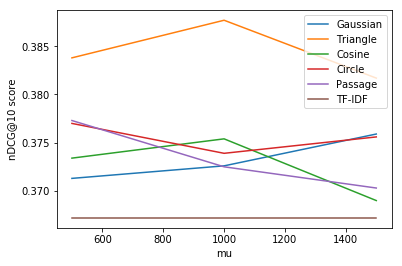

In [50]:
def plot_plm_results():
    scores = [
        [PLM_Gaussian_500_results['ndcg_cut_10']['all'], PLM_Gaussian_1000_results['ndcg_cut_10']['all'], PLM_Gaussian_1500_results['ndcg_cut_10']['all']],
        [PLM_Triangle_500_results['ndcg_cut_10']['all'], PLM_Triangle_1000_results['ndcg_cut_10']['all'], PLM_Triangle_1500_results['ndcg_cut_10']['all']],
        [PLM_Cosine_500_results['ndcg_cut_10']['all'], PLM_Cosine_1000_results['ndcg_cut_10']['all'], PLM_Cosine_1500_results['ndcg_cut_10']['all']],
        [PLM_Circle_500_results['ndcg_cut_10']['all'], PLM_Circle_1000_results['ndcg_cut_10']['all'], PLM_Circle_1500_results['ndcg_cut_10']['all']],
        [PLM_Passage_500_results['ndcg_cut_10']['all'], PLM_Passage_1000_results['ndcg_cut_10']['all'], PLM_Passage_1500_results['ndcg_cut_10']['all']]
    ]
    
    parameters = [500,1000,1500]
    
    labels = ["Gaussian", "Triangle", "Cosine", "Circle", "Passage"]
    
    for ind, label in enumerate(labels):
        num_scores = [float(s) for s in scores[ind]]
        plt.plot(parameters, num_scores, label=label)
    
    # Add also TF-IDF
    num_scores = 3 * [float(TFIDF_results_val['ndcg_cut_10']['all'])]
    plt.plot(parameters, num_scores, label="TF-IDF")
    plt.legend()
    plt.xlabel("mu")
    plt.ylabel('nDCG@10 score')
    plt.show()
plot_plm_results()

#### Positional Language Model scores upon validation set for different μ values and kernels
![PLM scores](PLM.png)

## Statistical significance of the results with the two-tailed paired Student t-test

We apply statistical significance tests of the results using two-tailed paired Student t-tests.

* Two-tailed paired Student t-test is applied upon two populations with the following hypotheses:
    1. Null hypothesis $H_0$: the means of the two populations are equal.
    2. Alternative hypothesis $H_a$: the means of the two populations are not equal.

* For each possible pair of retrieval methods, we take their results which consist of 4 evaluation metrics.

* Four evaluation metrics means that four experiments were conducted, therefore we compare each metric upon the pair results. Having 4 evaluation metrics and 5 different retrieval methods, we conculde that we have to perform (5!)*4 = 60 statistical significance tests.

* In order to tackle the multiple comparisons problem between the 4 conducted experiments, we apply the Šidák correction which states that in each comparison we use:
$$\alpha_{\text{{per comparison}}} = 1-(1-\alpha)^{1/m}$$

,where m=4 (the number of experiments) and α=0.05

The code below creates a table presenting the results.

In [52]:
run_models = {
    "tfidf" : "TF-IDF", "bm25" : "BM25", "JelinekMercer01" : "Jelinek-Mercer", 
    "DirichletPrior500" : "Dirichlet Prior Smoothing", "AbsoluteDiscounting09" : "Absolute Discounting", 
    "plm_triangle_1000" : "PLM with Triangle Kernel"
}

def compute_statistical_significance(run_models):
    """Applies two-tailed paired Student t-test upon each pair of retrieval methods for each score.
    
    Keyword parameters:
    run_models -- a dictionary with keys the run model filenames and values the corresponding retrieval method name.
    """
    
    
    
    # Result list
    results = []
    
    # Calibrate the level of α according to Šidák correction for 4 experiments. 
    alpha = 1 - (1-0.05)**(1/4)
    
    print("Computing statistical significance with two-tailed paired Student t-test using Šidák correction")
    print("Null hypothesis: equal averages.")
    print("Alternative hypothesis: inequal averages.")
    print("Conducted Experiments: 4")
    print("alpha value:", alpha)
    
    # For each run model
    for i, run in enumerate(run_models):
        models_to_compare = list(run_models.keys())[(i+1):]
        if models_to_compare:
            # Take any other model to compare with
            for comp_run in models_to_compare:
                # Get the scores of each run file
                a = evaluate(test_set, run)
                b = evaluate(test_set, comp_run)
                # For each score metric
                for metric in ["ndcg_cut_10", "map_cut_1000", "P_5", "recall_1000"]:
                    x = [float(a[metric][key]) for key in a[metric].keys() if key != "all"]
                    y = [float(b[metric][key]) for key in b[metric].keys() if key != "all"]
                    _, p = ttest_rel(x,y)
                    if p > alpha or math.isnan(p):
                        results.append([metric, run_models[run], run_models[comp_run], str(1) if math.isnan(p) else str(p), "not rejected"])
                    elif p <= alpha:
                        results.append([metric, run_models[run], run_models[comp_run], str(p), "rejected"])
    table = pd.DataFrame(results, columns=["Metric", "Model 1", "Model 2", "p-value", "Outcome"])
    table.index = np.arange(1, len(table) + 1)
    display(table)
    return table

table = compute_statistical_significance(run_models)

Computing statistical significance with two-tailed paired Student t-test using Šidák correction
Null hypothesis: equal averages.
Alternative hypothesis: inequal averages.
Conducted Experiments: 4
alpha value: 0.012741455098566168


,Metric,Model 1,Model 2,p-value,Outcome
1,ndcg_cut_10,TF-IDF,BM25,0.54616811868,not rejected
2,map_cut_1000,TF-IDF,BM25,0.739269264159,not rejected
3,P_5,TF-IDF,BM25,0.284916168242,not rejected
4,recall_1000,TF-IDF,BM25,0.840091387089,not rejected
5,ndcg_cut_10,TF-IDF,Jelinek-Mercer,0.000239062778789,rejected
6,map_cut_1000,TF-IDF,Jelinek-Mercer,0.000116294645219,rejected
7,P_5,TF-IDF,Jelinek-Mercer,0.000119902648562,rejected
8,recall_1000,TF-IDF,Jelinek-Mercer,0.000634426417932,rejected
9,ndcg_cut_10,TF-IDF,Dirichlet Prior Smoothing,0.588497434799,not rejected
10,map_cut_1000,TF-IDF,Dirichlet Prior Smoothing,0.401969816411,not rejected


# Task 2: Latent Semantic Models (LSMs) [15 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

In [ ]:
from gensim import corpora

import copy
import gensim
import logging
import pyndri
import pyndri.compat
import sys
import os
from gensim.models import lsimodel 
from gensim.models import tfidfmodel
from collections import defaultdict
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity 
from scipy import spatial
import heapq
from operator import itemgetter

#### CREATING CORPUS AND DICTIONARY

In [ ]:
if not os.path.isfile("outfile"):
    #tokenize each document and save it to an array 
    all_docs=[]
    for doc_id in range(index.document_base(),index.maximum_document()):
        example_document,doc = index.document(doc_id)
        all_docs.append([id2token[word_id] for word_id in doc if word_id > 0])

    with open('outfile', 'wb') as fp:
        pickle.dump(all_docs, fp)
else:
    with open ('outfile', 'rb') as fp:
        all_docs = pickle.load(fp)

In [ ]:
from gensim import corpora

import copy
import gensim
import logging
import pyndri
import pyndri.compat
import sys
import os


logging.basicConfig(level=logging.INFO)

if not os.path.isfile("corpus_ls"):

    #Create & Save  Dictionary
    dictionary = gensim.corpora.dictionary.Dictionary(documents=all_docs)
    dictionary.save("dictionary_ls")
    #Create & Save Corpus
    corpus = [dictionary.doc2bow(doc) for doc in  all_docs]
    corpora.MmCorpus.serialize("corpus_ls", corpus)
    #corpus.save("corpus_ls")
else:
    dictionary = corpora.Dictionary.load("dictionary_ls")
    corpus = corpora.MmCorpus("corpus_ls")
    
print(corpus)

### LSI

In [ ]:
if not os.path.isfile("lsi_model"):
    # first, transform word counts to tf-idf weights
    tfidf_model = tfidfmodel.TfidfModel(corpus, id2word = dictionary, normalize = True)
    
    # then find the transformation from tf-idf to latent space
    lsi_model = lsimodel.LsiModel(tfidf_model[corpus], id2word = dictionary, num_topics = 64)
    
    # Save the models to disk
    tfidf_model.save("tfidf_model")
    lsi_model.save("lsi_model")
else:
    tfidf_model = gensim.models.TfidfModel.load("tfidf_model")
    lsi_model = gensim.models.LsiModel.load("lsi_model")

### LDA

In [ ]:
from gensim.models import ldamodel  

if not os.path.isfile("lda_model"):
    
    lda_model = ldamodel.LdaModel(corpus, id2word = dictionary, num_topics = 64)
    lda_model.save("lda_model")
else:
    lda_model = gensim.models.LdaModel.load("lda_model") 

num_topics = 64

In [ ]:
if not os.path.isfile("tfidf_docs1000"):
    tfidf_docs1000, rest_ranking1000 = get_tfidf_rankings(1000)

    with open('tfidf_docs1000', 'wb') as fp:
        pickle.dump(tfidf_docs1000, fp)
else:
    with open ('tfidf_docs1000', 'rb') as fp:
        tfidf_docs1000 = pickle.load(fp)

### LSI Evaluation

In [ ]:
def lsi_score(tfidf_docs1000):
    """
    LSI
    Transform each query and each document with LSI model
    Cosine similarity to the two vec QueryLsi and DocLSI
    
    """
    filename='./ap_88_89/topics_title'

    with open(filename, 'r') as f_topics:
        queries = parse_topics([f_topics])
        
    scores = defaultdict(list)
    
    for doc_id in tfidf_docs1000.keys():
        for query_id in tfidf_docs1000[doc_id]:
            
            #constructing the query representation######
            query = queries[query_id]
            # Tokenize the query
            tokenized_query = index.tokenize(query)
            # Get token ids for tokens in the query
            token_ids = [token2id.get(token, 0) for token in tokenized_query]
            # Remove stopwords
            token_ids = [id2token[t] for t in token_ids if t > 0]

            query_bow = dictionary.doc2bow(token_ids)
            query_lsi = lsi_model[tfidf_model[query_bow]]
            query_lsi = [x[1] for x in query_lsi]
            ##############################

            #construction the doc representation
            example_document,doc = index.document(doc_id)
            doc = [id2token[word_id] for word_id in doc if word_id > 0]                        
            doc_bow = dictionary.doc2bow(doc)
            doc_lsi = lsi_model[tfidf_model[doc_bow]]
            doc_lsi = [x[1] for x in doc_lsi]
            
            #score similarity 
            scores[query_id].append((doc_id , 1-spatial.distance.cosine(query_lsi,doc_lsi)))
            
            #sort the top1000 scores for each query
            for query_id in scores:
                scores[query_id] = heapq.nlargest(1000, scores[query_id], itemgetter(1))

    
    return scores

In [ ]:
if not os.path.isfile("LSI_tfidf_scores"):
    scores_lsi = lsi_score(tfidf_docs1000)

    with open('LSI_tfidf_scores', 'wb') as fp:
        pickle.dump(scores_lsi, fp)
else:
    with open ('LSI_tfidf_scores', 'rb') as fp:
        scores_lsi = pickle.load(fp)

In [ ]:
with open('LSI_tfidf_scores.run', 'w') as the_file:
    for query_id in scores_lsi:
        for i in range(len(scores_lsi[query_id])):
            the_file.write(query_id+" Q0 "+index.document(scores_lsi[query_id][i][0])[0]+" "+str(i)+" "+str(scores_lsi[query_id][i][1])+" "+"LSI_tfidf_scores\n")
    the_file.close()

In [ ]:
LSI_results = evaluate(test_set, "LSI_tfidf_scores")
print("LSI has the f|ollowing scores upon the test set:")
print("nDCG@10:\t{0}".format(LSI_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(LSI_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(LSI_results['P_5']['all']))
print("Recall@1000:\t{0}".format(LSI_results['recall_1000']['all']))

### LDA Evaluation

In [ ]:
def lda_score(tfidf_docs1000):

    filename='./ap_88_89/topics_title'

    with open(filename, 'r') as f_topics:
        queries = parse_topics([f_topics])

    scores = defaultdict(list)

    for doc_id in tfidf_docs1000.keys():
        for query_id in tfidf_docs1000[doc_id]:
            
            #constructing the query repr######
            query = queries[query_id]
            # Tokenize the query
            tokenized_query = index.tokenize(query)
            # Get token ids for tokens in the query
            token_ids = [token2id.get(token, 0) for token in tokenized_query]
            # Remove stopwords
            #token_ids = [t for t in token_ids if t > 0]
            token_ids = [id2token[t] for t in  token_ids if t > 0]
            query_bow = dictionary.doc2bow(token_ids)
            query_lda = lda_model[query_bow]
            
            flag = False
            for i in range(0,64):
                for item in query_lda:
                    if item[0] == i:
                        flag = True
                if(flag == False):
                    query_lda.append((i,0))
                flag = False
            
            query_lda = sorted(query_lda, key=lambda x: x[0])
            query_lda = [x[1] for x in query_lda]
            ##############################

            
            example_document,doc = index.document(doc_id)
            doc = [id2token[word_id] for word_id in doc if word_id > 0]            
            #doc_terms = Counter(token_ids)            
            doc_bow = dictionary.doc2bow(doc)
            doc_lda = lda_model[doc_bow]
            flag2 = False
            #make 64 as num of topics parmtr
            for i in range(0,64):
                for item in doc_lda:
                    if item[0] == i:
                        flag2 = True
                if(flag2 == False):
                    doc_lda.append((i,0))
                flag2 = False
            doc_lda = sorted(doc_lda, key=lambda x: x[0])
            doc_lda = [x[1] for x in doc_lda]
            
            scores[query_id].append((doc_id , 1-spatial.distance.cosine(query_lda,doc_lda)))


    for query_id in scores:
        scores[query_id] = heapq.nlargest(1000, scores[query_id], itemgetter(1))
    
    return scores

In [ ]:
if not os.path.isfile("LDA_tfidf_scores"):
    scores_lda = lda_score(tfidf_docs1000)

    with open('LDA_tfidf_scores', 'wb') as fp:
        pickle.dump(scores_lda, fp)
else:
    with open ('LDA_tfidf_scores', 'rb') as fp:
        scores_lda = pickle.load(fp)

In [ ]:
#Construct the run scores file

with open('LDA_tfidf_scores.run', 'w') as the_file:
    for query_id in scores_lda:
        for i in range(len(scores_lda[query_id])):
            the_file.write(query_id+" Q0 "+index.document(scores_lda[query_id][i][0])[0]+" "+str(i)+" "+str(scores_lda[query_id][i][1])+" "+"LSA_tfidf_scores\n")
    the_file.close()

In [ ]:
LDA_results = evaluate(test_set, "LDA_tfidf_scores")
print("LDA has the f|ollowing scores upon the test set:")
print("nDCG@10:\t{0}".format(LDA_results['ndcg_cut_10']['all']))
print("MAP@1000:\t{0}".format(LDA_results['map_cut_1000']['all']))
print("Precision@5:\t{0}".format(LDA_results['P_5']['all']))
print("Recall@1000:\t{0}".format(LDA_results['recall_1000']['all']))

### Significance tests

In [ ]:
run_models = {
    "tfidf" : "TF-IDF", "LSI_tfidf_scores" : "LSI on best-tfidf-pairs", 
    "LDA_tfidf_scores" : "LDA on best-tfidf-pairs"
}

table2 = compute_statistical_significance(run_models)

# Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

https://www.microsoft.com/en-us/research/wp-content/uploads/2016/04/pp1291-Nalisnick.pdf

In [ ]:
import pyndri.compat

## Train the model
model = gensim.models.Word2Vec(
    size=500,  # Embedding size
    iter=10,  # Number of iterations.
    workers=8,  # Number of workers.
)

dictionary = pyndri.extract_dictionary(index)
sentences = pyndri.compat.IndriSentences(index, dictionary)

# Build vocab.
model.build_vocab(sentences, trim_rule=None)

model.train(sentences,total_examples=model.corpus_count, epochs=model.iter)
model.save("10Epochs_500")

print('Trained model = ', model)

In [ ]:
from gensim.models import Word2Vec

def embedAllDocuments():
    doc2embed = {}
    model = Word2Vec.load("10Epochs_500")
    dictionary = pyndri.extract_dictionary(index)
    for int_doc_id in range(index.document_base(), index.maximum_document()):
        if document_lengths[int_doc_id] > 0:
            ext_doc_id, doc_token_ids = index.document(int_doc_id)
            D = np.zeros(500)
            for d in doc_token_ids:
                if d != 0:
                    try:
                        dj = model.wv[dictionary[d]] / np.linalg.norm(model.wv[dictionary[d]])
                        D += dj
                    except KeyError:
                        continue

            doc2embed[int_doc_id] = (1/document_lengths[int_doc_id]) * D
            if int_doc_id % 10000 == 0:
                print("Document " + str(int_doc_id) + " out of " + str(index.maximum_document()))
    return doc2embed

doc2embed = embedAllDocuments()

In [ ]:
with open('doc2embed20.pickle', 'wb') as handle:
    pickle.dump(doc2embed, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('doc2embed20.pickle', 'rb') as handle:
    doc2embed = pickle.load(handle)

In [ ]:
def run_retrieval2(model_name, score_fn):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)

    data = {}

    # Fill the data dictionary. 
    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
    
    start_time = time.time()
    
    for doc in range(index.document_base(), num_documents+1):
        if doc % 10000 == 0: 
            print(str(doc) + " out of " + str(index.maximum_document()))
        # Skip empty documents
        if index.document_length(doc) == 0:
            continue
        
        # Get document id
        ext_doc_id = index.document(doc)[0]
        
        # Iterate over topic queries
        for query_id in tokenized_queries.keys():
            if query_id not in data.keys():
                data[query_id] = []
            # Iterate over terms of topic query and calculate score
            score = score_fn(doc, query_id)
            data[query_id].append(tuple(((score, ext_doc_id))))
    # Save to file
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)
    
    print('Retrieved in {0} seconds'.format(time.time() - start_time))
    print()

In [ ]:
from collections import OrderedDict
model = Word2Vec.load("10Epochs_500")
dictionary = pyndri.extract_dictionary(index)

def wordEmbedingForRanking(int_document_id, query_id):
    desm = 0
    for query_term_id in tokenized_queries[query_id]:
        try:
            x = np.array([np.transpose(model.wv[dictionary[query_term_id]])])
            y = doc2embed[int_document_id]
            desm += (np.dot(x, y) / (np.linalg.norm(model.wv[dictionary[query_term_id]]) * np.linalg.norm(y)))
        except KeyError:
            continue
    desm = (1/len(tokenized_queries[query_id])) * desm
    return desm[0]
run_retrieval2("wordEmbedingForRanking", wordEmbedingForRanking)
# tokenized_queries

# Task 4: Learning to rank (LTR) [15 points] (open-ended) ###

In this task you will get an introduction into learning to rank for information retrieval.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1, Task 2 and Task 3 as features. Think about other features you can use (e.g. query/document length). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

You are adviced to start some pointwise learning to rank algorithm e.g. logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set. More advanced learning to rank algorithms will be appreciated when grading.

In [ ]:
import pandas as pd
def get_tfidf_rankings(n=100):
    
    # Get a mapping from document names (e.g. "AP880318-0287) to their dictionary IDs.
    doc2id = {}
    for int_doc_id in range(index.document_base(), index.maximum_document()):
        doc2id[index.document(int_doc_id)[0]] = int_doc_id
        
    # Get tfidf rankings
    names = ["qid", "Q0", "docid", "rank", "similarity", "run"]
    data = pd.read_csv('tfidf.run', sep=' ', header=None, names=names)
    
    #data = data[["qid", "docid"]]
    last_data = pd.DataFrame(columns=["qid", "docid"])
    final_data = pd.DataFrame(columns=["qid", "docid"])
    for query in tokenized_queries.keys():
        temp = data.loc[data['qid'] == int(query)]
        
        # Take rest of rankings
        rest = data.loc[data['qid'] == int(query)].tail(1000-n)
        
        # Add large negative values to similarity
        rest["similarity"] = range(-9999 ,-9999-rest["similarity"].shape[0], -1)
        
        # Append to last rankings table
        last_data = last_data.append(rest)
        
        # Get the top n rankings
        final_data = final_data.append(temp.head(n))
    
    # Create a dictionary for the top n rankings:
    # results: doc_id -> list of queries which have this doc in their top n rankings
    final_data = final_data[["qid", "docid"]]
    results = defaultdict(list)
    for _, row in final_data.iterrows():
        results[doc2id[row["docid"]]].append(str(row["qid"]))
        
    return results, last_data

def get_test_set_top(n=5):
    
    # Get a mapping from document names (e.g. "AP880318-0287) to their dictionary IDs.
    doc2id = {}
    for int_doc_id in range(index.document_base(), index.maximum_document()):
        doc2id[index.document(int_doc_id)[0]] = int_doc_id
    results = {}
    # Get tfidf rankings
    names = ["qid", "Q0", "docid", "rel"]
    data = pd.read_csv('ap_88_89/qrel_test', sep=' ', header=None, names=names)
    unique_queries = data['qid'].unique()
    for q in unique_queries:
        docs = data.loc[data['qid'] == q][:5]['docid']
        docids = [doc2id[doc] for doc in docs]
        results[q] = docids
    
    return results

In [ ]:
import csv
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def extract_features_and_labels(kfold_index, all_queries):
    query_index_train = []
    for rindex in kfold_index:
        query_index_train.append(all_queries[rindex])
    features = []
    classes = []
    all_query_id = []
    documents = []
    for document, queries in tfidf_docs1000.items():
        for query in queries:
            if query in query_index_train:
                score_tf = 0
                counter = 0
                score_bm = 0
                for query_term_id in tokenized_queries[query]:
                    if document not in inverted_index[query_term_id]:
                        document_term_freq = 0
                    else:
                        document_term_freq = inverted_index[query_term_id][document]
                    score_tf += tfidf(document, query_term_id, document_term_freq)
                    score_bm += BM25(document, query_term_id, document_term_freq)
                    counter = counter +1
                all_query_id.append(query)
                documents.append(document)
                features.append([score_tf, score_bm, counter])
                classes.append(docquery2relivance[query][document])
    return features, classes, all_query_id, documents

def evaluate_ltr(test_index, predictions, queries, documents):
    ranking = get_test_set_top(5)
    for query_index in test_index:
        query_id = all_queries[query_index]
        indices = [index for index, value in enumerate(queries) if value == query_id]
        query_pred = [queries[i] for i in indices]
        doc_pred = [documents[i] for i in indices]
        score_predictions = [predictions[i] for i in indices]

        sorted_predictions, sorted_docs = zip(*sorted(zip(score_predictions, doc_pred)))
        top5_docs_predicted = sorted_docs[-5:]
        top5_docs_actual = ranking[int(query_id)]
        TP = len(set(top5_docs_actual).intersection(top5_docs_predicted))
        FP = 5-TP
        precision = TP/(TP+FP)
        allPrecision.append(precision)
#         print(np.mean(allPrecision))
    return allPrecision

doc2id = {}
for int_doc_id in range(index.document_base(), index.maximum_document()):
    doc2id[index.document(int_doc_id)[0]] = int_doc_id

docquery2relivance = defaultdict(lambda: defaultdict(int))
with open("ap_88_89/qrel_test", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ')
    for row in reader:
        try:
            docquery2relivance[row[0]][doc2id[row[2]]] = int(row[3])
        except KeyError:
            print(row[0],row[2])
            
all_queries = list(docquery2relivance.keys())
kf = KFold(n_splits=10)
tfidf_docs1000, _ = get_tfidf_rankings(1000)
precisionPerFold = []
for train_index, test_index in kf.split(all_queries):
    features, classes, _, _ = extract_features_and_labels(train_index,all_queries)
    features_test, classes_test, queries_test, document_test = extract_features_and_labels(test_index,all_queries)
    
    classifier = LogisticRegression()
    classifier.fit(features, classes)
    x = classifier.decision_function(features_test)
    allPrecision = evaluate_ltr(test_index, x, queries_test, document_test)
    meanPrecision = np.mean(allPrecision)
    precisionPerFold.append(meanPrecision)
print(np.mean(precisionPerFold))

In [ ]:
doc2id = {}
for int_doc_id in range(index.document_base(), index.maximum_document()):
    doc2id[index.document(int_doc_id)[0]] = int_doc_id
print(doc2id['AP880218-0195'])
print(doc2id['AP880229-0184'])
print(doc2id['AP880301-0033'])
print(doc2id['AP880302-0095'])
print(doc2id['AP880312-0116'])

# Task 5: Write a report [15 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.


# Appendix
Auxialiary code. Can be uncommented to reproduce results for:


* Plotting the Language Models

In [ ]:
# Jelinek Mercer Plotting

# JelinekMercer02 = partial(JelinekMercer, lambda_param = 0.2)
# run_retrieval('JelinekMercer02', JelinekMercer02)
# JelinekMercer03 = partial(JelinekMercer, lambda_param = 0.3)
# run_retrieval('JelinekMercer03', JelinekMercer03)
# JelinekMercer04 = partial(JelinekMercer, lambda_param = 0.4)
# run_retrieval('JelinekMercer04', JelinekMercer04)
# JelinekMercer06 = partial(JelinekMercer, lambda_param = 0.6)
# run_retrieval('JelinekMercer06', JelinekMercer06)
# JelinekMercer07 = partial(JelinekMercer, lambda_param = 0.7)
# run_retrieval('JelinekMercer07', JelinekMercer07)
# JelinekMercer08 = partial(JelinekMercer, lambda_param = 0.8)
# run_retrieval('JelinekMercer08', JelinekMercer08)

# JM_results_02 = evaluate(validation_set, "JelinekMercer02")
# JM_results_03 = evaluate(validation_set, "JelinekMercer03")
# JM_results_04 = evaluate(validation_set, "JelinekMercer04")
# JM_results_06 = evaluate(validation_set, "JelinekMercer06")
# JM_results_07 = evaluate(validation_set, "JelinekMercer07")
# JM_results_08 = evaluate(validation_set, "JelinekMercer08")

# scores = [JM_results_01['ndcg_cut_10']['all'],
#          JM_results_02['ndcg_cut_10']['all'],
#          JM_results_03['ndcg_cut_10']['all'],
#          JM_results_04['ndcg_cut_10']['all'],
#          JM_results_05['ndcg_cut_10']['all'],
#          JM_results_06['ndcg_cut_10']['all'],
#          JM_results_07['ndcg_cut_10']['all'],
#          JM_results_08['ndcg_cut_10']['all'],
#          JM_results_09['ndcg_cut_10']['all']]
# plot_results(scores, [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], "lambda")

# Dirichlet Prior Plotting

# DirichletPrior750 = partial(DirichletPrior, mu=750)
# run_retrieval('DirichletPrior750', DirichletPrior750)
# DirichletPrior1250 = partial(DirichletPrior, mu=1250)
# run_retrieval('DirichletPrior1250', DirichletPrior1250)


# Get all evaluation results.
# DP_results_750 = evaluate(validation_set, "DirichletPrior750")
# DP_results_1250 = evaluate(validation_set, "DirichletPrior1250")


# scores = [DP_results_500['ndcg_cut_10']['all'],
#          DP_results_750['ndcg_cut_10']['all'],
#          DP_results_1000['ndcg_cut_10']['all'],
#          DP_results_1250['ndcg_cut_10']['all'],
#          DP_results_1500['ndcg_cut_10']['all']]
# plot_results(scores, [500, 750, 1000, 1250, 1500], "mu")



# # Absolute discounting plotting
# AbsoluteDiscounting02 = partial(AbsoluteDiscounting, delta = 0.2)
# run_retrieval('AbsoluteDiscounting02', AbsoluteDiscounting02)
# AbsoluteDiscounting03 = partial(AbsoluteDiscounting, delta = 0.3)
# run_retrieval('AbsoluteDiscounting03', AbsoluteDiscounting03)
# AbsoluteDiscounting04 = partial(AbsoluteDiscounting, delta = 0.4)
# run_retrieval('AbsoluteDiscounting04', AbsoluteDiscounting04)
# AbsoluteDiscounting06 = partial(AbsoluteDiscounting, delta = 0.6)
# run_retrieval('AbsoluteDiscounting06', AbsoluteDiscounting06)
# AbsoluteDiscounting07 = partial(AbsoluteDiscounting, delta = 0.7)
# run_retrieval('AbsoluteDiscounting07', AbsoluteDiscounting07)
# AbsoluteDiscounting08 = partial(AbsoluteDiscounting, delta = 0.8)
# run_retrieval('AbsoluteDiscounting08', AbsoluteDiscounting08)



# # Get all evaluation results.
# AD_results_02 = evaluate(validation_set, "AbsoluteDiscounting02")
# AD_results_03 = evaluate(validation_set, "AbsoluteDiscounting03")
# AD_results_04 = evaluate(validation_set, "AbsoluteDiscounting04")
# AD_results_06 = evaluate(validation_set, "AbsoluteDiscounting06")
# AD_results_07 = evaluate(validation_set, "AbsoluteDiscounting07")
# AD_results_08 = evaluate(validation_set, "AbsoluteDiscounting08")

# scores = [AD_results_01['ndcg_cut_10']['all'],
#          AD_results_02['ndcg_cut_10']['all'],
#          AD_results_03['ndcg_cut_10']['all'],
#          AD_results_04['ndcg_cut_10']['all'],
#          AD_results_05['ndcg_cut_10']['all'],
#          AD_results_06['ndcg_cut_10']['all'],
#          AD_results_07['ndcg_cut_10']['all'],
#          AD_results_08['ndcg_cut_10']['all'],
#          AD_results_09['ndcg_cut_10']['all']]
# plot_results(scores, [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], "delta")